<a href="https://colab.research.google.com/github/WarrenWatts/ESET-315-Project-Binary-Class-IDS/blob/main/ESET_315_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Save a copy of the dataset (IoT-23_Normal.csv and IoT-23_C&C.csv) and this template to your drive before beginning. 

DO NOT EDIT THIS FILE. COPY TO YOUR OWN DRIVE.

Some mistakes are irreversible and you may need to restart your runtime. You can do so by clicking "Runtime" -> "Restart Runtime" from the toolbar at the top of the Colab page.

**Mount the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc, classification_report

**Input Data**

(Step 1) Import the data from your drive and convert into a DataFrame. The example below shows how to import one csv file into a DataFrame. You should be importing both the IoT-23_Normal.csv and the IoT-23_C&C.csv files (two files) and create two DataFrames (df1 and df2). Due to the size of the IoT-23_Normal.csv file, this may take a few minutes. 

In [ ]:
#example (you will probably need to change the directory to fit your Google Drive)
#tf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IoT-23_C&C.csv', iterator=True, low_memory=False)
#df1 = pd.concat(tf1, ignore_index=True)

###insert code to import data from drive here. You should created two dataframes: df1 and df2 ###

tf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IoT-23_C&C.csv', iterator=True, low_memory=False)
df1 = pd.concat(tf1, ignore_index=True)
tf2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IoT-23_Normal.csv', iterator=True, low_memory=False)
df2 = pd.concat(tf2, ignore_index=True)


FileNotFoundError: ignored

(Step 2) combine the two DataFrames into one using the .append function()

In [ ]:
#example
#data = pd.DataFrame()
#data = df1.append(df2)

###insert code to combine dataframes here (be sure to name your combined dataframes 'data' or the rest of the code will not work)###

data = pd.DataFrame(df1)
data = df1.append(df2)


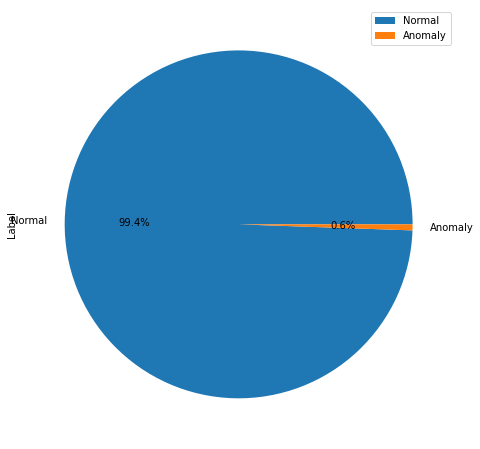

In [ ]:
data['Label'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend(bbox_to_anchor=(1, 1))

**Data Conditioning**

(Step 3) Notice the dataset is not very well balanced with many more normal samples than anomaly/attack samples. The anomalies are the samples from the C&C file. Try balancing the dataset using the .sample() function. The .sample() function randomly chooses samples from the DataFrame. In the example below, df1 is reduced to **#** number samples.

We want to balance our dataset (have about the same number of anomaly and normal packets). Does this mean we should reduce the number of anomaly packets or normal packets? 

In [ ]:
#example 
#df1 = df1.sample(#)
#recommend you start with a larger sample then go down from there or you might have to restart runtime
###Insert code to sample a number ranging from (0 to 50000) to make it balanced, and redefine data to reflect the new balanced data###

df2 = df2.sample(23981)
data = df1.append(df2)
###There are many more normal pkts than anomaly pkts,so we should choose a sample size = # of anomaly pkts for the normal pkts###


Your dataset should now have approximately the same number of samples in each class. Run the next cell to check. If it does not have the same number, try changing the numbers from the previous code cell and try again.

Anomaly    23981
Normal     23981
Name: Label, dtype: int64
47962
(47962, 85)


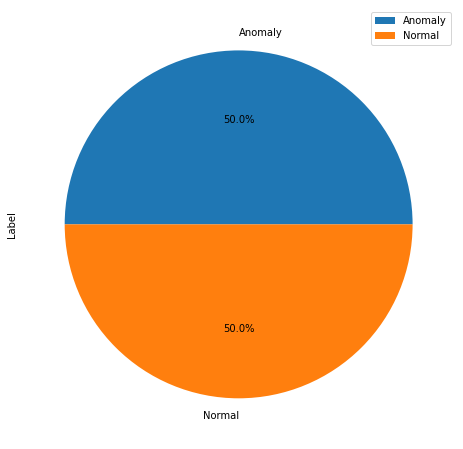

In [ ]:
data['Label'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend(bbox_to_anchor=(1, 1))
print(data['Label'].value_counts())
print(data['Label'].value_counts().sum())
print(data.shape) #prints out the dimensions of the DataFrame (rows, columns)

(Step 4) Data Preprocessing

There are some features (or variables) that are harmful or not useful in identifying anomalies using ML models. Such features can cause overfitting.  These include unique identifiers and duplicate categories. For our purposes, socket features (like IP addresses and port numbers) are not good for generalization to other devices.

Open the IoT-23_C&C.csv file (using Excel) and take a look at the features avaiable (the top row). From the print(data.shape) above, we can see that there are 85 features available, or 83 not including the 2 label features. 

Labels show what class the packet is (i.e., a normal packet or an attack packet). Our dataset has two different labels: 'Label' and 'Sub_Cat'. These can be seen in .csv files at the right most column. in the C&C.csv file, the entire 'Label' column is filled with 'Anomaly' and the 'Sub_Cat' column is all 'C&C', meaning that the C&C.csv file only contains anomalous packets of the C&C cyberattack class.

Some features could cause overfitting problems, meaning the the model fit too specifically to this dataset and won't work well in a more general context. For example, in our case, IP addresses are probably a good feature to remove because they are specific to this dataset.

Analyze and remove the features that could cause issues in our model. 
(**Hint1:** remove the Sub_Cat feature, but keep the Label feature which will be dealt with later) 
**(Hint2:** I removed about seven features but you can remove more or less as long as you can explain your reasoning)

In [ ]:
#remove unwanted features
#example using the .drop() function 
#data.drop(['Src_IP','Dst_IP', 'Sub_Cat'],axis=1,inplace=True)
#.drop function reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

data.drop(['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port','Sub_Cat', 'Timestamp'],axis=1,inplace=True)
#IP addresses and Port Numbers removed as detailed in the above step, as well as the Sub_Cat feature. (Only parts detailed in Step info!)

print(data.shape)


(47962, 78)


NaN (Not a Number) and inf (infinity) values often can not be used by the ML model, so let's check the dataset for any of these values.

In [ ]:
nancheck = data.isnull().values.any() #only checks for NaN values
print(nancheck)

False


Remove the NaN and inf values

In [ ]:
#to be safe, always run
data = data[~data.isin([np.nan,np.inf,-np.inf]).any(1)] 
print(data['Label'].value_counts())

Anomaly    23981
Normal     23981
Name: Label, dtype: int64


Although the Decision Tree model we are using can theoretically use strings as labels just fine, many implementations don't allow it. Its a common practice to convert the labels to integer values. (Hint: did you remove features that are strings, as opposed to integers, when removing unwanted features in the beginning of Step 4?)

Because the dataset comes with labels, our model will undergo supervised learning. Of course, we don't want our model to initially know what kind of sample (normal or anomaly) each on is so we need to separate our labels from the dataset.

The labels are commonly referred to as the y data, while the rest is the x data.

In [ ]:
#make y_data

# attack_type is equal to an array with the value ['Anomaly', 'Normal']
attack_type = data['Label'].unique() #Finds all the unique values in Label column (which are 'Normal' and 'Anomaly')
attack_type = attack_type.tolist() #Makes array into a list
y_data = data['Label'].apply(attack_type.index)
y_data = y_data.drop(columns='index')


In [ ]:
#print to make sure the labels were converted into integers
print(y_data.value_counts())

#print(y_data.value_counts())

1    23981
0    23981
Name: Label, dtype: int64


We have duplicated the labels into another series/dataframe (named y_data), but it still needs to be dropped from the original dataframe (named data).

In [ ]:
#remove 'Label' from x_data using the .drop() function

data.drop(['Label'],axis=1,inplace=True)
###insert code to remove labels from data###

(Step 5) Train/Test Split

Next, we should allocate a fraction of our dataset for training the model, and the rest for testing the model for accuracy and other metrics. The idea is to see how well our model performs on data it has not already seen before. If both the train and test sets have poor accuracy, we underfit our model. If the train has good accuracy, but the test does not, then the model has overfit to the training data. For the purposes of this project, we are unable to see the training data accuracy, but the test accuracy should be enough to know if you need to make adjustments to your model.

In [ ]:
#train/test split reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.33) ###insert test size and any other parameters you wish to use###)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#X_train has 32134 Rows and 77 Columns
#X_test has 15828 Rows and 77 Columns
#Y_train has 32134 Rows and 1 Column
#Y_test has 15828 Rows and 1 Column


(32134, 77) (15828, 77) (32134,) (15828,)


**ML Algorithms**

(Step 6) The Dummy Classifier can be used to establish a baseline for the actual model we want to use. Put simply, the Dummy Classifier just guesses what the sample is without trying to improve itself, thus establishing baseline performance.

In [ ]:
from sklearn.dummy import DummyClassifier
model_dummy = DummyClassifier(strategy="uniform", random_state=1)
model_dummy.fit(X_train, y_train)

DummyClassifier(random_state=1, strategy='uniform')

In [ ]:
y_predict_dummy = model_dummy.predict(X_test)
print('Baseline Accuracy Score: ', accuracy_score(y_test, y_predict_dummy))
print('Baseline Precision Score: ', precision_score(y_test, y_predict_dummy))

Baseline Accuracy Score:  0.5034748546878949
Baseline Precision Score:  0.503107953824686


Your Dummy Classifier should produce about 50% accuracy and precision as expected of randomly guessing a binary classification. This accuracy is not great and we should expect our Decision Tree Classifier to perform much better. 

(Step 7) The Decision Tree Classifier is generally a fast model. However, our dataset has a large number of features which can slow down the process. Change the parameters of the Decision Tree Classifier below to speed up the process, while still producing a good accuracy score. (Hint: Look at Project Instructions document links to find what parameters the DecisionTreeClassifier has)

In [ ]:
#make and train model
clf = tree.DecisionTreeClassifier(max_depth=28)
clf = clf.fit(X_train, y_train)
#print(clf.tree_.max_depth) #Used to find Max Depth 

(Step 7a) Results of the Decision Tree are produced by the next three cells.

In [ ]:
#print accuracy and precision score
y_pred = clf.predict(X_test)
print("Test Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Test Precision Score: ", precision_score(y_test, y_pred))

Test Accuracy Score:  0.9942506949709375
Test Precision Score:  0.994809469553108


In [ ]:
#print classification report
CR=classification_report(y_test, y_pred)
print("Classification Report: ")
print(CR)

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7920
           1       0.99      0.99      0.99      7908

    accuracy                           0.99     15828
   macro avg       0.99      0.99      0.99     15828
weighted avg       0.99      0.99      0.99     15828



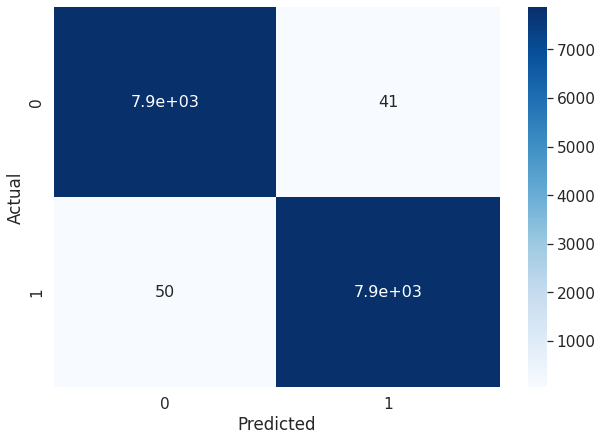

In [ ]:
#print confusion matrix
import seaborn as sn
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm,columns=np.unique(y_test),index=np.unique(y_test))
df_cm.index.name='Actual'
df_cm.columns.name='Predicted'
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm,cmap='Blues',annot=True,annot_kws={'size':16})

(Step 8) Try training and testing the dataset on a Random Forest Classifier. 

(Step 8a) Be sure to print the accuracy, precision, classification report, and confusion matrix.

Test Accuracy Score:  0.994882486732373
Test Precision Score:  0.9961962723469
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7920
           1       1.00      0.99      0.99      7908

    accuracy                           0.99     15828
   macro avg       0.99      0.99      0.99     15828
weighted avg       0.99      0.99      0.99     15828



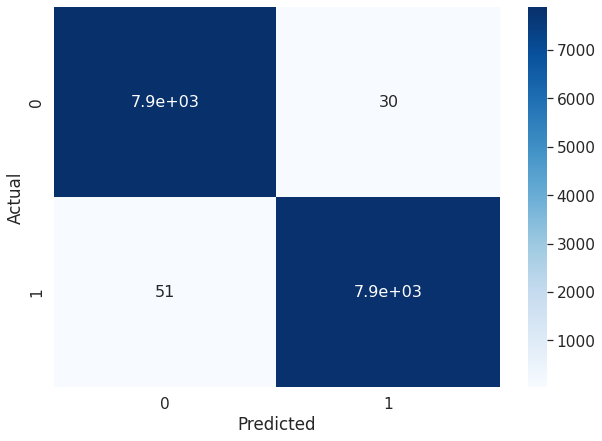

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, max_depth=28)
rfc = rfc.fit(X_train, y_train)

y_pred2 = rfc.predict(X_test)
print("Test Accuracy Score: ", accuracy_score(y_test, y_pred2))
print("Test Precision Score: ", precision_score(y_test, y_pred2))

CR2=classification_report(y_test, y_pred2)
print("Classification Report: ")
print(CR2)

cm2=confusion_matrix(y_test,y_pred2)
df_cm2=pd.DataFrame(cm2,columns=np.unique(y_test),index=np.unique(y_test))
df_cm2.index.name='Actual'
df_cm2.columns.name='Predicted'
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm2,cmap='Blues',annot=True,annot_kws={'size':16})


(Step 9) Bonus: Import the Torii Attack data and test your models using the Torii attacks instead of the C&C attacks.

Anomaly    23981
Normal     23981
Name: Label, dtype: int64 

47962 

(47962, 85) 

(47962, 78) 

False 

Anomaly    23981
Normal     23981
Name: Label, dtype: int64 

1    23981
0    23981
Name: Label, dtype: int64 

(32134, 77) (15828, 77) (32134,) (15828,) 

Baseline Accuracy Score:  0.4959565327268132
Baseline Precision Score:  0.4975263224660662 

24


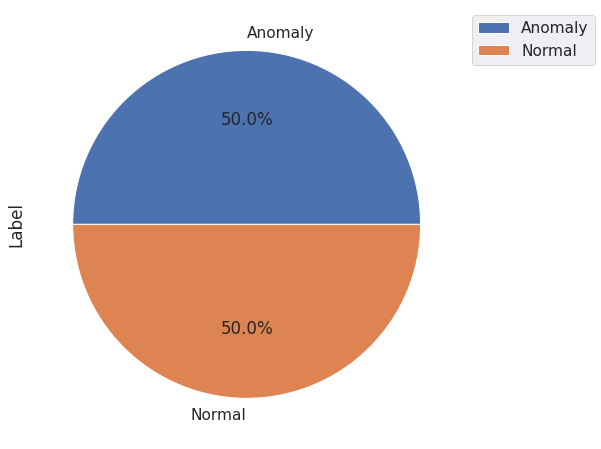

In [ ]:
tf3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Copy of IoT-23_Torii.csv', iterator=True, low_memory=False)
df3 = pd.concat(tf3, ignore_index=True)
data2 = pd.DataFrame(df3)
data2 = df3.append(df2)

df3 = df3.sample(23981)
data2 = df3.append(df2)

data2['Label'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend(bbox_to_anchor=(1, 1))
print(data2['Label'].value_counts(), '\n')
print(data2['Label'].value_counts().sum(), '\n')
print(data2.shape, '\n') #prints out the dimensions of the DataFrame (rows, columns)

data2.drop(['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port','Sub_Cat', 'Timestamp'],axis=1,inplace=True)
print(data2.shape, '\n')

nancheck = data2.isnull().values.any() #only checks for NaN values
print(nancheck, '\n')

data2 = data2[~data2.isin([np.nan,np.inf,-np.inf]).any(1)] 
print(data2['Label'].value_counts(), '\n')

attack_type2 = data2['Label'].unique() #Finds all the unique values in Label column (which are 'Normal' and 'Anomaly')
attack_type2 = attack_type2.tolist() #Makes array into a list
y_data2 = data2['Label'].apply(attack_type.index)
y_data2 = y_data2.drop(columns='index')

print(y_data2.value_counts(), '\n')

data2.drop(['Label'],axis=1,inplace=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, y_data2, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n')

model_dummy2 = DummyClassifier(strategy="uniform", random_state=1)
model_dummy2.fit(X_train2, y_train2)

y_predict_dummy2 = model_dummy2.predict(X_test2)
print('Baseline Accuracy Score: ', accuracy_score(y_test2, y_predict_dummy2))
print('Baseline Precision Score: ', precision_score(y_test2, y_predict_dummy2), '\n')

clf2 = tree.DecisionTreeClassifier(max_depth=22)
clf2 = clf2.fit(X_train2, y_train2)
print(clf.tree_.max_depth)


Answer the questions given on the Project Instructions document and complete your paper using the IEEE template.

Test Accuracy Score:  0.9998104624715694
Test Precision Score:  0.9997481108312343 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7889
           1       1.00      1.00      1.00      7939

    accuracy                           1.00     15828
   macro avg       1.00      1.00      1.00     15828
weighted avg       1.00      1.00      1.00     15828



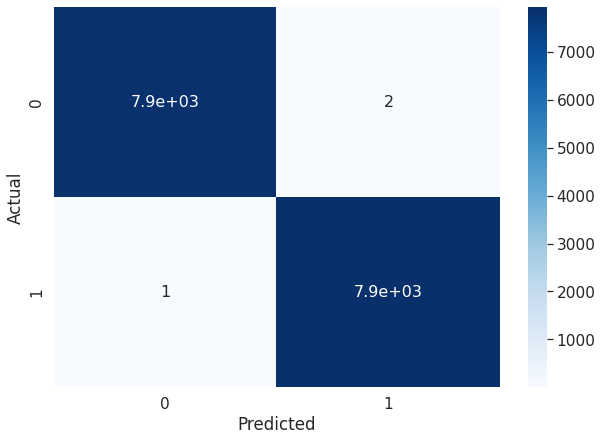

In [ ]:
###Decision Tree Classifier###

y_pred3 = clf2.predict(X_test2)
print("Test Accuracy Score: ", accuracy_score(y_test2, y_pred3))
print("Test Precision Score: ", precision_score(y_test2, y_pred3), '\n')

CR3=classification_report(y_test2, y_pred3)
print("Classification Report: ")
print(CR3)

cm3=confusion_matrix(y_test2,y_pred3)
df_cm3=pd.DataFrame(cm3,columns=np.unique(y_test2),index=np.unique(y_test2))
df_cm3.index.name='Actual'
df_cm3.columns.name='Predicted'
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm3,cmap='Blues',annot=True,annot_kws={'size':16})


Test Accuracy Score:  0.9998104624715694
Test Precision Score:  0.9996222613951146
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7889
           1       1.00      1.00      1.00      7939

    accuracy                           1.00     15828
   macro avg       1.00      1.00      1.00     15828
weighted avg       1.00      1.00      1.00     15828



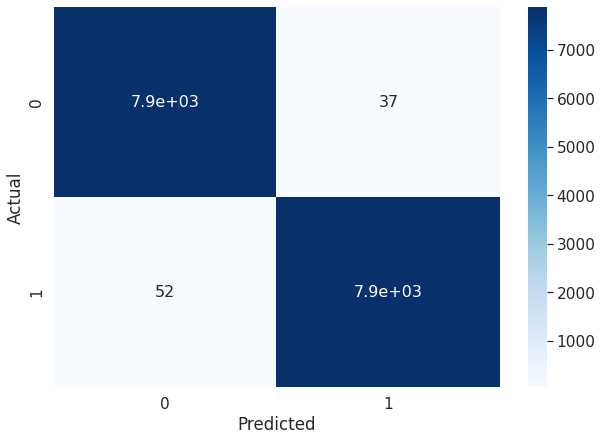

In [ ]:
###Random Forest Classifier###

rfc2 = RandomForestClassifier(n_estimators=10, max_depth=22)
rfc2 = rfc2.fit(X_train2, y_train2)

y_pred4 = rfc2.predict(X_test2)
print("Test Accuracy Score: ", accuracy_score(y_test2, y_pred4))
print("Test Precision Score: ", precision_score(y_test2, y_pred4))

CR4=classification_report(y_test2, y_pred4)
print("Classification Report: ")
print(CR4)

cm4=confusion_matrix(y_test2,y_pred4)
df_cm4=pd.DataFrame(cm4,columns=np.unique(y_test2),index=np.unique(y_test2))
df_cm4.index.name='Actual'
df_cm4.columns.name='Predicted'
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm2,cmap='Blues',annot=True,annot_kws={'size':16})
